## Clusters algorithms using skit-learn
#### http://scikit-learn.org/stable/modules/clustering.html

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
/home/ale/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  w

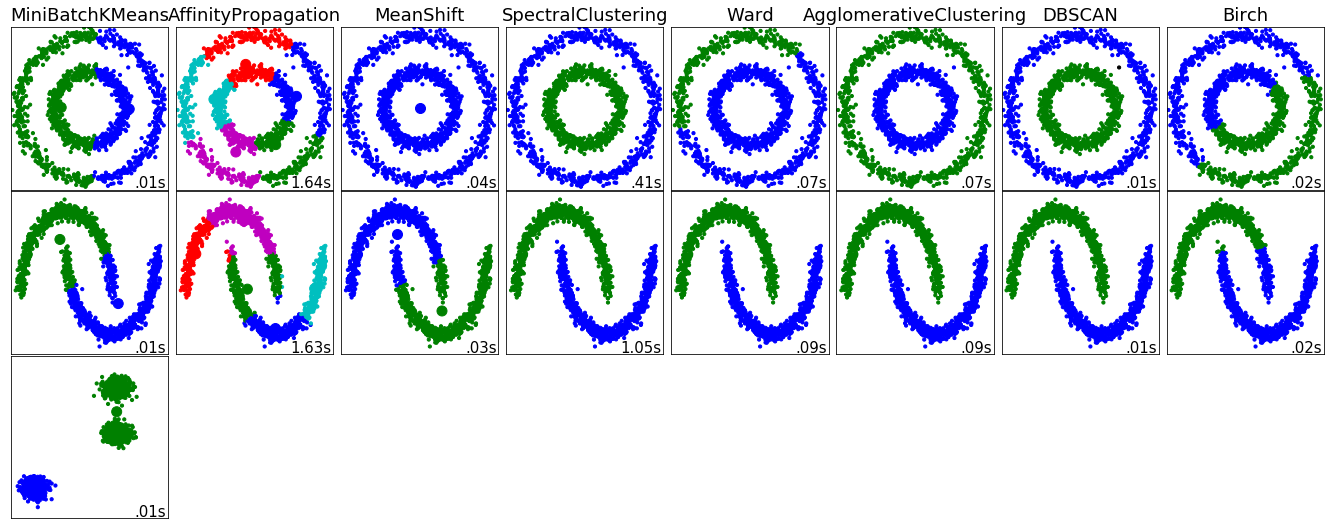

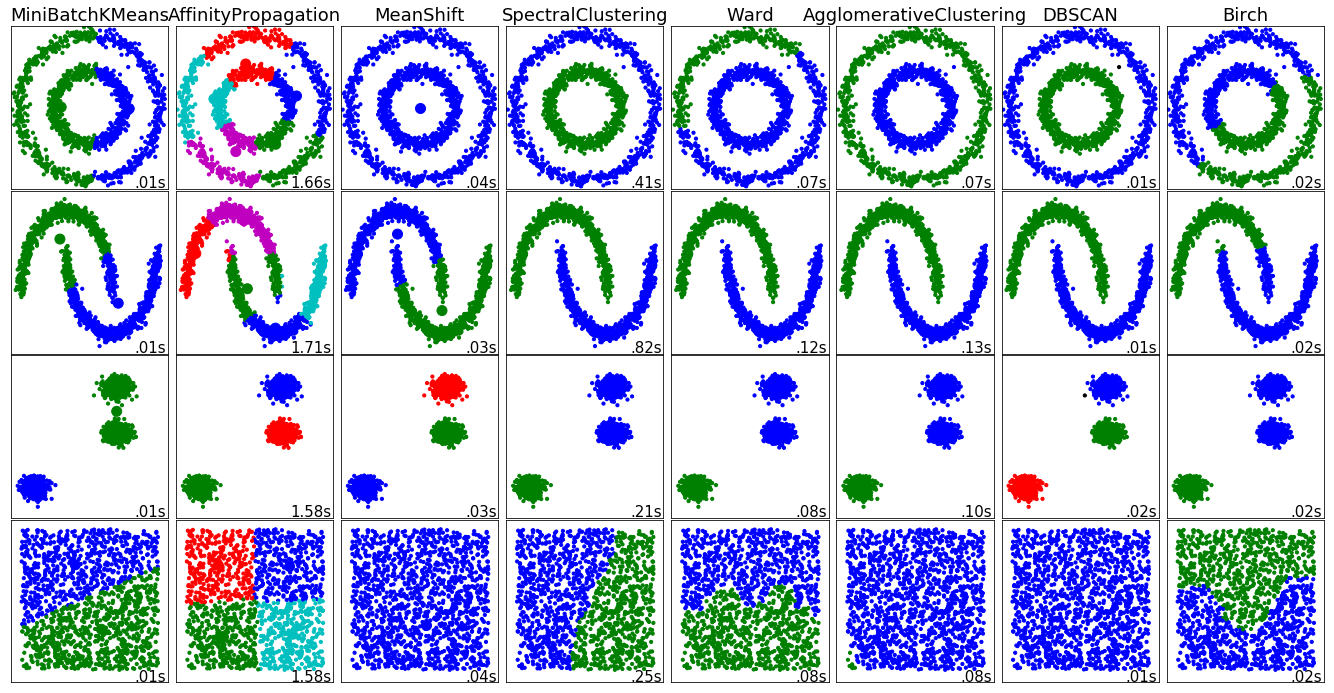

In [7]:
%run plot_cluster_comparison.py

###  K-means
- requires the number of clusters to be specified
- It scales well to large number of samples
- assumption that clusters are convex and isotropic
- It responds poorly to elongated clusters, or manifolds with irregular shapes
- Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate distance problem and speed up the computations
- k-means can suffer from the initialization, use the init='kmeans++' parameter which initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization
- MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time

In [8]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

In [9]:
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [10]:
# compute K-MEANS
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

In [11]:
# compute MINIBATCH K-MEANS
mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

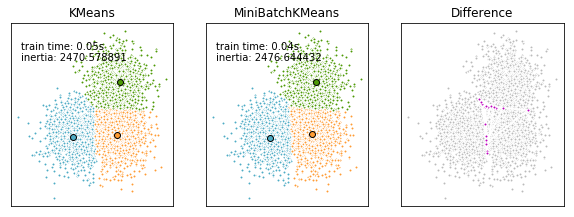

In [12]:
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# Let's pair the cluster centers per closest one.
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' % (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w', markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w', markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

### Affinity Propagation¶
-  it chooses the number of clusters based on the data provided => the two important parameters are the preference, which controls how many exemplars are used, and the damping factor
- The main drawback of Affinity Propagation is its complexity (N^2 * T, T=number of iterations until convergence) which can be reducible if a sparse similarity matrix is used
- AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

In [13]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

In [14]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5, random_state=0)

In [15]:
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


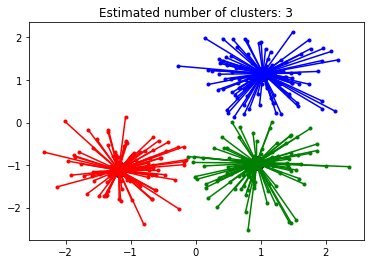

In [16]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

###  Mean Shift
- centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region
- These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.
- The algorithm automatically sets the number of clusters using the parameter bandwidth, which dictates the size of the region to search through
- This parameter can be set manually, but can be estimated using the provided estimate_bandwidth function, which is called if the bandwidth is not set.
- Labelling a new sample is performed by finding the nearest centroid for a given sample.

In [17]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

In [18]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

In [19]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3


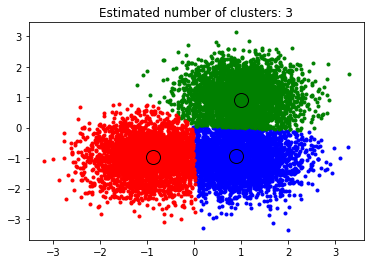

In [20]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### DBSCAN
- clusters found by DBSCAN can be any shape
- Any sample that is not a core sample, and is at least eps in distance from any core sample, is considered an outlier by the algorithm
- The algorithm is non-deterministic, but the core samples will always belong to the same clusters (although the labels may be different).
- Other than the ordering of the dataset, the algorithm is deterministic, making the results relatively stable between runs on the same data.
- you can use your own function to calculate the distance
- This implementation is by default not memory efficient. A couple of mechanisms for getting around this are: metric='precomputed'.
- The dataset can be compressed, either by removing exact duplicates if these occur in your data, or by using BIRCH. Then you only have a relatively small number of representatives for a large number of points. You can then provide a sample_weight when fitting DBSCAN.

In [21]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [22]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
X = StandardScaler().fit_transform(X)

In [23]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


/home/ale/anaconda3/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


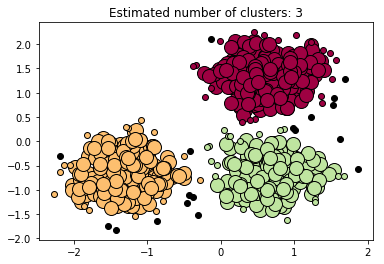

In [24]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Spectral clustering¶
- low-dimension embedding of the affinity matrix between samples, followed by a KMeans in the low dimensional space
- especially efficient if the affinity matrix is sparse and the pyamg module is installed
- performs very well with the images
- Note that if the values of your similarity matrix are not well distributed, e.g. with negative values or with a distance matrix rather than a similarity, the spectral problem will be singular and the problem not solvable. In which case it is advised to apply a transformation to the entries of the matrix. For instance, in the case of a signed distance matrix, is common to apply a heat kernel
- the "discretize" strategy is 100% reproducible while the "kmeans" depends on the random initial state

In [25]:
import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version

# load the raccoon face as a numpy array
from scipy import misc
face = misc.face(gray=True)

# Resize it to 10% of the original size to speed up the processing
face = sp.misc.imresize(face, 0.10) / 255.

# Convert the image into a graph with the value of the gradient on the edges.
graph = image.img_to_graph(face)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg installed)
N_REGIONS = 10

Spectral clustering: kmeans, 2.81s
Spectral clustering: discretize, 3.40s


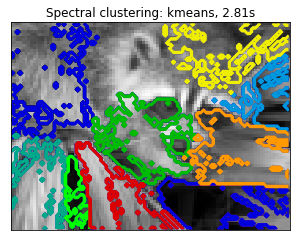

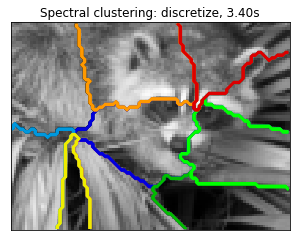

In [26]:
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(face.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(face, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1, colors=[plt.cm.spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()

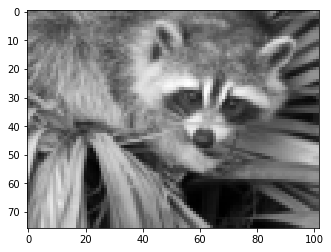

In [27]:
plt.imshow(face, cmap=plt.cm.gray)
plt.show()

##### a little bit more about affinity and similarity matrix of an image
An image has an implicit spatial metric between pixels, but the spectral clustering method does not handle this. It views an image as a bag of pixels.

Regarding M, N and K; M * N = K. Both expressions describe the number of objects that will be clustered, which in your case is the number of pixels.

The affinity matrix, A is a decimated version of the similarity matrix, S. E.g. if two objects/pixels are not similar enough, they are not adjacent.

One way tho construct the adjacency matrix is the following:

S(i, j) = color_intensity_distance( pixel(i), pixel(j) )

A(i, j) = exp( - S(i,j) ), if S(i,j) <= epsilon

A(i, j) = 0, otherwise
To improve your performance, you should search for a sparse matrix library. They are very efficient at handling matrices with many zeroes.

### Hierarchical clustering
- build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree 
- root of the tree = all the samples
- AgglomerativeClustering: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy: 1) Ward minimizes the sum of squared differences within all clusters. 2) Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters. 3) Average linkage minimizes the average of the distances between all observations of pairs of clusters.
- connectivity constraints can be added to this algorithm (only adjacent clusters can be merged together), through a connectivity matrix that defines for each sample the neighboring samples 
- These constraint are useful to impose a certain local structure, but they also make the algorithm faster, especially when the number of the samples is high.
- The connectivity matrix can be constructed from a-priori information (cluster web pages by only merging pages with a link pointing from one to another) or it can also be learned from the data, for instance using sklearn.neighbors.kneighbors_graph to restrict merging to nearest neighbors, or using sklearn.feature_extraction.image.grid_to_graph to enable only merging of neighboring pixels on an image
- The FeatureAgglomeration uses agglomerative clustering to group together features that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool
- Average and complete linkage can be used with a variety of distances (or affinities), in particular Euclidean distance (l2), Manhattan distance (or Cityblock, or l1), cosine distance (cosine distance is interesting because it is invariant to global scalings of the signal), or any precomputed affinity matrix.

In [28]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

In [29]:
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)
# Make it thinner
X[:, 1] *= .5

In [30]:
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 0.04s
Number of points: 1500


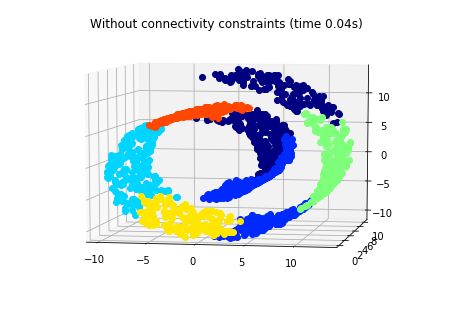

In [31]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.plot3D(X[label == l, 0], X[label == l, 1], X[label == l, 2], 'o', color=plt.cm.jet(np.float(l) / np.max(label + 1)))
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)
plt.show()

In [32]:
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

In [33]:
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute structured hierarchical clustering...
Elapsed time: 0.09s
Number of points: 1500


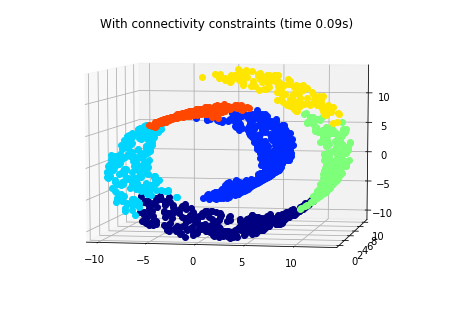

In [34]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.plot3D(X[label == l, 0], X[label == l, 1], X[label == l, 2], 'o', color=plt.cm.jet(float(l) / np.max(label + 1)))
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

### Birch
- The Birch builds a tree
- The Birch algorithm has two parameters, the threshold and the branching factor. The branching factor limits the number of subclusters in a node and the threshold limits the distance between the entering sample and the existing subclusters.
- This reduced data can be further processed by feeding it into a global clusterer
- Birch does not scale very well to high dimensional data
-  if one wants a large number of subclusters Birch is more useful than MiniBatchKMeans.

Birch without global clustering as the final step took 2.35 seconds
n_clusters : 158
Birch with global clustering as the final step took 2.40 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 2.28 seconds


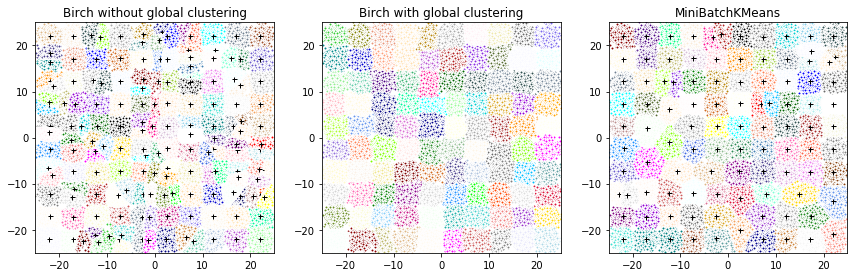

In [35]:
from itertools import cycle
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs


# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis], np.ravel(yy)[:, np.newaxis]))

# Generate blobs to do a comparison between MiniBatchKMeans and Birch.
X, y = make_blobs(n_samples=100000, centers=n_centres, random_state=0)


# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with Birch with and without the final clustering step
# and plot.
birch_models = [Birch(threshold=1.7, n_clusters=None), Birch(threshold=1.7, n_clusters=100)]
final_step = ['without global clustering', 'with global clustering']

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print("Birch %s as the final step took %0.2f seconds" % (info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=col, marker='.')
        if birch_model.n_clusters is None:
            ax.plot(this_centroid[0], this_centroid[1], '+', markerfacecolor=col, markeredgecolor='k', markersize=5)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(init='k-means++', n_clusters=100, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0, random_state=0)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_, range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(this_centroid[0], this_centroid[1], '+', markeredgecolor='k', markersize=5)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()

### Evaluation of Cluster algorithm performance
- Divided in algorithm that use the ground truth and algorithm which do not use the ground truth

#### Adjusted Rand index
- Given the knowledge of the ground truth class the adjusted Rand index is a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization
- Perfect labeling is scored 1.0, Bad (e.g. independent labelings) have negative or close to 0.0 scores, Random (uniform) label assignments have a ARI score close to 0.0
- No assumption is made on the cluster structure

In [36]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.adjusted_mutual_info_score(labels_true, labels_pred)  

0.2250422831983088

#### Mutual Information based scores 
- require the knowledge of the ground truth classes, measures the agreement of the two assignments
- Two different normalized versions of this measure are available, Normalized Mutual Information(NMI) and Adjusted Mutual Information(AMI)
- Random (uniform) label assignments have a AMI score close to 0.0
- Bounded range [0, 1] where 0 indicate purely independent label assignments and a AMI of exactly 1 indicates that the two label assignments are equal
- No assumption is made on the cluster structure
- The AMI should be more robust than the NMI one

In [37]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

print(metrics.adjusted_mutual_info_score(labels_true, labels_pred), metrics.mutual_info_score(labels_true, labels_pred))

0.225042283198 0.462098120373


#### Homogeneity, completeness and V-measure
- require the knowledge of the ground truth classes
- homogeneity: each cluster contains only members of a single class; completeness: all members of a given class are assigned to the same cluster; Their harmonic mean is called V-measure and is actually equivalent to the mutual information (NMI)
- Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score
- v_measure_score is symmetric but this is not the case for completeness_score and homogeneity_score (homogeneity_score(a, b) == completeness_score(b, a))
- clustering with bad V-measure can be qualitatively analyzed in terms of homogeneity and completeness to better feel what ‘kind’ of mistakes is done by the assignment
- No assumption is made on the cluster structure
- not normalized with regards to random labeling (this means that depending on the number of samples, clusters and ground truth classes, a completely random labeling will not always yield the same values)

In [38]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

print(metrics.homogeneity_score(labels_true, labels_pred))
print(metrics.completeness_score(labels_true, labels_pred))
print(metrics.v_measure_score(labels_true, labels_pred))
print(metrics.homogeneity_completeness_v_measure(labels_true, labels_pred))

0.666666666667
0.420619835714
0.515803742979
(0.66666666666666685, 0.420619835714305, 0.51580374297938891)


#### Fowlkes-Mallows scores
- require the knowledge of the ground truth classes
- is defined as the geometric mean of the pairwise precision and recall: FMI = TP/sqrt((TP+FP)*(TP+FN))
- Random (uniform) label assignments have a FMI score close to 0.0
- Bounded range [0, 1] where close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement.
- No assumption is made on the cluster structure

In [39]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.fowlkes_mallows_score(labels_true, labels_pred)  

0.47140452079103173

#### Silhouette Coefficient
- ground truth labels are not known, higher Silhouette Coefficient score relates to a model with better defined clusters
- The Silhouette Coefficient s for a single sample is then given as: s=(b-a)/max(a,b) where (a): The mean distance between a sample and all other points in the same class. (b): The mean distance between a sample and all other points in the next nearest cluster.
- The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.
- It can be used to select the number of clusters with silhouette analysis on KMeans clustering

In [40]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
dataset = datasets.load_iris()
X = dataset.data
y = dataset.target

In [41]:
import numpy as np
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.55259194452136762

For n_clusters = 2 The average silhouette_score is : 0.704978749608


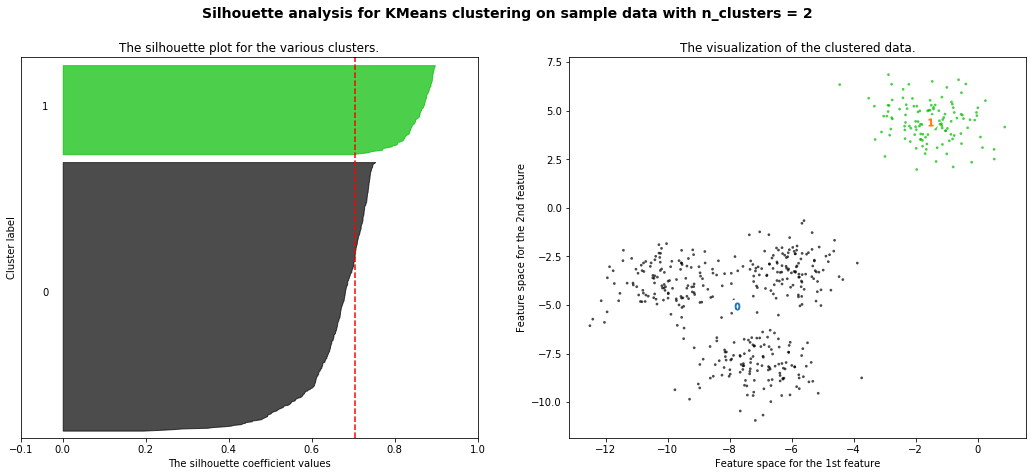

For n_clusters = 3 The average silhouette_score is : 0.588200401213


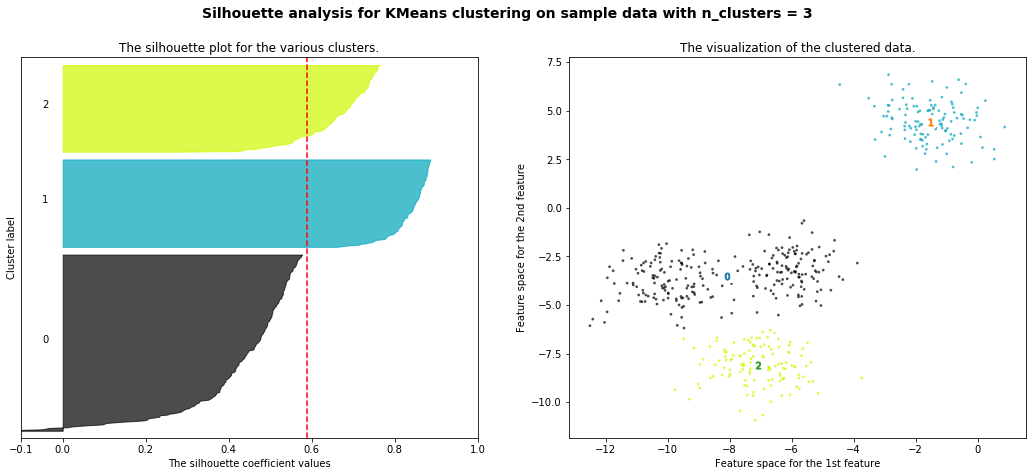

For n_clusters = 4 The average silhouette_score is : 0.650518663273


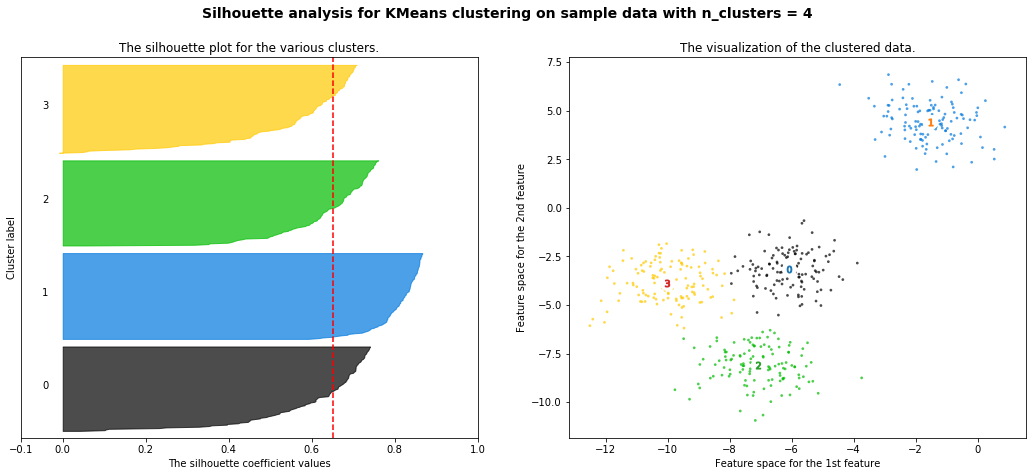

For n_clusters = 5 The average silhouette_score is : 0.563764690262


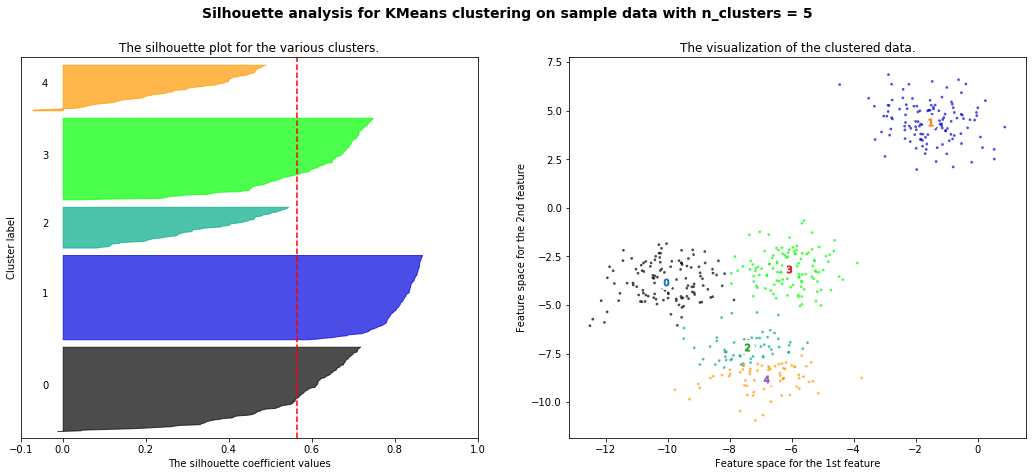

For n_clusters = 6 The average silhouette_score is : 0.450466629437


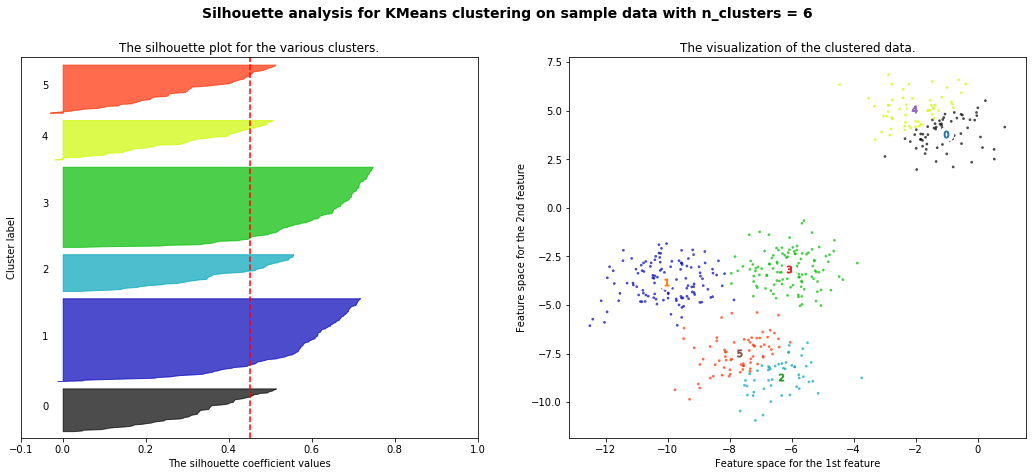

In [42]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close together.
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, center_box=(-10.0, 10.0), shuffle=True, 
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

    plt.show()

#### Calinski-Harabaz Index
- ground truth labels are not known,  higher Calinski-Harabaz score relates to a model with better defined clusters
- it is an intelligent ratio of the between and the within of all clusters
- The score is fast to compute
- generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN

In [43]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
dataset = datasets.load_iris()
X = dataset.data
y = dataset.target

In [44]:
import numpy as np
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.calinski_harabaz_score(X, labels)

560.39992424664024